In [44]:
from non_local_detector.core import hmm_smoother
import jax

import jax.numpy as jnp

initial_distribution = jnp.array([0.5, 0.5])
# transition_matrix = jnp.stack(
#     (
#         jnp.array([[0.7, 0.3], [0.4, 0.6]]),
#         jnp.array([[0.8, 0.2], [0.4, 0.6]]),
#         jnp.array([[0.7, 0.3], [0.4, 0.6]]),
#     ),
#     axis=0,
# )

transition_matrix = jnp.array([[0.7, 0.3], [0.4, 0.6]])
log_likelihoods = jnp.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])


# hmm_smoother(initial_distribution, transition_matrix, log_likelihoods)
initial_distribution.shape, transition_matrix.shape, log_likelihoods.shape

((2,), (2, 2), (3, 2))

In [6]:
x = jnp.arange(5)

x / x.sum(), x / x.sum(keepdims=True)

(Array([0. , 0.1, 0.2, 0.3, 0.4], dtype=float32),
 Array([0. , 0.1, 0.2, 0.3, 0.4], dtype=float32))

In [3]:
(
    marginal_loglik,
    filtered_probs,
    predicted_probs,
    smoothed_probs,
) = hmm_smoother(initial_distribution, transition_matrix, log_likelihoods)

In [10]:
import jax
import jax.numpy as jnp
from functools import partial
from non_local_detector.core import get_trans_mat, hmm_filter


def get_trans_mat(transition_matrix, transition_fn, t):
    if transition_fn is not None:
        return transition_fn(t)
    return transition_matrix[t] if transition_matrix.ndim == 3 else transition_matrix


def _normalize(u, axis=0, eps=1e-15):
    """Normalizes the values within the axis in a way that they sum up to 1.

    Args:
        u: Input array to normalize.
        axis: Axis over which to normalize.
        eps: Minimum value threshold for numerical stability.

    Returns:
        Tuple of the normalized values, and the normalizing denominator.
    """
    u = jnp.clip(u, a_min=eps, a_max=None)
    c = u.sum(axis=axis)
    return u / c, c


# Helper functions for the two key filtering steps
def _condition_on(probs, ll):
    """Condition on new emissions, given in the form of log likelihoods
    for each discrete state, while avoiding numerical underflow.

    Args:
        probs(k): prior for state k
        ll(k): log likelihood for state k

    Returns:
        probs(k): posterior for state k
    """
    ll_max = ll.max()
    ll_max = jnp.where(jnp.isfinite(ll_max), ll_max, 0.0)
    new_probs, norm = _normalize(probs * jnp.exp(ll - ll_max))
    log_norm = jnp.log(norm) + ll_max
    return new_probs, log_norm


@partial(jax.jit, static_argnames=["transition_fn"])
def hmm_filter(
    initial_distribution,
    transition_matrix,
    log_likelihoods,
    transition_fn=None,
):
    r"""Forwards filtering

    Transition matrix may be either 2D (if transition probabilities are fixed) or 3D
    if the transition probabilities vary over time. Alternatively, the transition
    matrix may be specified via `transition_fn`, which takes in a time index $t$ and
    returns a transition matrix.

    Args:
        initial_distribution: $p(z_1 \mid u_1, \theta)$
        transition_matrix: $p(z_{t+1} \mid z_t, u_t, \theta)$
        log_likelihoods: $p(y_t \mid z_t, u_t, \theta)$ for $t=1,\ldots, T$.
        transition_fn: function that takes in an integer time index and returns a $K \times K$ transition matrix.

    Returns:
        filtered posterior distribution

    """
    num_timesteps = log_likelihoods.shape[0]

    def _step(carry, t):
        log_normalizer, predicted_probs = carry

        A = get_trans_mat(transition_matrix, transition_fn, t)

        filtered_probs, log_norm = _condition_on(predicted_probs, log_likelihoods[t])
        log_normalizer += log_norm
        predicted_probs_next = A.T @ filtered_probs

        return (log_normalizer, predicted_probs_next), (filtered_probs, predicted_probs)

    (log_normalizer, _), (filtered_probs, predicted_probs) = jax.lax.scan(
        _step, (0.0, initial_distribution), jnp.arange(num_timesteps)
    )

    return (
        log_normalizer,
        filtered_probs,
        predicted_probs,
    )


@partial(jax.jit, static_argnames=["transition_fn"])
def hmm_smoother2(
    initial_distribution,
    transition_matrix,
    log_likelihoods,
    transition_fn=None,
):
    r"""Computed the smoothed state probabilities using a general
    Bayesian smoother.

    Transition matrix may be either 2D (if transition probabilities are fixed) or 3D
    if the transition probabilities vary over time. Alternatively, the transition
    matrix may be specified via `transition_fn`, which takes in a time index $t$ and
    returns a transition matrix.

    *Note: This is the discrete SSM analog of the RTS smoother for linear Gaussian SSMs.*

    Args:
        initial_distribution: $p(z_1 \mid u_1, \theta)$
        transition_matrix: $p(z_{t+1} \mid z_t, u_t, \theta)$
        log_likelihoods: $p(y_t \mid z_t, u_t, \theta)$ for $t=1,\ldots, T$.
        transition_fn: function that takes in an integer time index and returns a $K \times K$ transition matrix.

    Returns:
        posterior distribution

    """
    num_timesteps = log_likelihoods.shape[0]

    # Run the HMM filter
    (marginal_loglik, filtered_probs, predicted_probs) = hmm_filter(
        initial_distribution, transition_matrix, log_likelihoods, transition_fn
    )

    # Run the smoother backward in time
    def _step(smoothed_probs_next, t):
        A = get_trans_mat(transition_matrix, transition_fn, t)

        # Fold in the next state (Eq. 8.2 of Saarka, 2013)
        # If hard 0. in predicted_probs_next, set relative_probs_next as 0. to avoid NaN values
        relative_probs_next = jnp.where(
            jnp.isclose(predicted_probs[t + 1], 0.0),
            0.0,
            smoothed_probs_next / predicted_probs[t + 1],
        )
        smoothed_probs = filtered_probs[t] * (A @ relative_probs_next)
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    # Run the HMM smoother
    _, smoothed_probs = jax.lax.scan(
        _step, filtered_probs[-1], jnp.arange(num_timesteps - 1), reverse=True
    )
    smoothed_probs = jnp.vstack([smoothed_probs, filtered_probs[-1]])

    return (
        marginal_loglik,
        filtered_probs,
        predicted_probs,
        smoothed_probs,
    )


# Run the smoother
(marginal_loglik2, filtered_probs2, predicted_probs2, smoothed_probs2) = hmm_smoother2(
    initial_distribution, transition_matrix, log_likelihoods
)

jnp.allclose(smoothed_probs, smoothed_probs2)

Array(True, dtype=bool)

In [11]:
@partial(jax.jit, static_argnames=["transition_fn"])
def hmm_smoother2(
    transition_matrix,
    filtered_probs,
    predicted_probs,
    initial_smoothed_probs,
    transition_fn=None,
):
    num_timesteps = filtered_probs.shape[0]

    def _step(smoothed_probs_next, t):
        A = get_trans_mat(transition_matrix, transition_fn, t)

        relative_probs_next = jnp.where(
            jnp.isclose(predicted_probs[t + 1], 0.0),
            0.0,
            smoothed_probs_next / predicted_probs[t + 1],
        )
        smoothed_probs = filtered_probs[t] * (A @ relative_probs_next)
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    _, smoothed_probs = jax.lax.scan(
        _step, initial_smoothed_probs, jnp.arange(num_timesteps - 1), reverse=True
    )

    return jnp.vstack([smoothed_probs, filtered_probs[-1]])


(marginal_loglik, filtered_probs, predicted_probs) = hmm_filter(
    initial_distribution, transition_matrix, log_likelihoods, transition_fn=None
)
smoothed_probs2 = hmm_smoother2(
    transition_matrix,
    filtered_probs,
    predicted_probs,
    transition_fn=None,
)
jnp.allclose(smoothed_probs, smoothed_probs2)

Array(True, dtype=bool)

In [23]:
# chunked version
@partial(jax.jit, static_argnames=["transition_fn"])
def hmm_smoother2(
    transition_matrix,
    filtered_probs,
    predicted_probs,
    initial_smoothed_probs,
    transition_fn=None,
):
    num_timesteps = filtered_probs.shape[0]

    def _step(smoothed_probs_next, t):
        A = get_trans_mat(transition_matrix, transition_fn, t)

        relative_probs_next = jnp.where(
            jnp.isclose(predicted_probs[t + 1], 0.0),
            0.0,
            smoothed_probs_next / predicted_probs[t + 1],
        )
        smoothed_probs = filtered_probs[t] * (A @ relative_probs_next)
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    _, smoothed_probs = jax.lax.scan(
        _step, initial_smoothed_probs, jnp.arange(num_timesteps - 1), reverse=True
    )

    return jnp.vstack([smoothed_probs, filtered_probs[-1]])


def chunk_smoother(
    initial_distribution,
    transition_matrix,
    log_likelihoods,
    transition_fn=None,
    chunk_size=2,
):
    n_time = log_likelihoods.shape[0]

    marginal_loglik = 0.0
    filtered_probs_list = []
    predicted_probs_list = []

    initial_distribution_chunk = initial_distribution

    for start in range(0, n_time, chunk_size):
        end = min(start + chunk_size, n_time)
        (chunk_marginal_loglik, chunk_filtered_probs, chunk_predicted_probs) = (
            hmm_filter(
                initial_distribution_chunk,
                transition_matrix,
                log_likelihoods[start:end],
                transition_fn=transition_fn,
            )
        )
        marginal_loglik += chunk_marginal_loglik
        filtered_probs_list.append(chunk_filtered_probs)
        predicted_probs_list.append(chunk_predicted_probs)

        initial_distribution_chunk = chunk_filtered_probs[0]

    filtered_probs = jnp.vstack(filtered_probs_list)
    predicted_probs = jnp.vstack(predicted_probs_list)

    smoothed_probs_list = []
    initial_smoothed_probs = filtered_probs[-1]

    for start in reversed(range(0, n_time, chunk_size)):
        end = min(start + chunk_size, n_time)
        smoothed_probs_chunk = hmm_smoother2(
            transition_matrix,
            filtered_probs[start:end],
            predicted_probs[start:end],
            initial_smoothed_probs,
            transition_fn=transition_fn,
        )
        smoothed_probs_list.insert(0, smoothed_probs_chunk)
        initial_smoothed_probs = smoothed_probs_chunk[0]

    smoothed_probs = jnp.vstack(smoothed_probs_list)

    return (
        marginal_loglik,
        filtered_probs,
        predicted_probs,
        smoothed_probs,
    )

In [24]:
(
    marginal_loglik2,
    filtered_probs2,
    predicted_probs2,
    smoothed_probs2,
) = chunk_smoother(initial_distribution, transition_matrix, log_likelihoods)

jnp.allclose(smoothed_probs, smoothed_probs2)

Array(False, dtype=bool)

In [25]:
jnp.allclose(filtered_probs, filtered_probs2)

Array(False, dtype=bool)

In [18]:
smoothed_probs2

Array([[0.7142802 , 0.2857198 ],
       [0.7378236 , 0.26217642],
       [0.697345  , 0.30265492]], dtype=float32)

In [26]:
filtered_probs

Array([[0.6899744 , 0.3100255 ],
       [0.7378236 , 0.26217642],
       [0.65117556, 0.34882444]], dtype=float32)

In [27]:
filtered_probs2

Array([[0.6899744 , 0.3100255 ],
       [0.7378236 , 0.26217642],
       [0.6456563 , 0.3543437 ]], dtype=float32)

In [29]:
jax.make_jaxpr(hmm_filter)(initial_distribution, transition_matrix, log_likelihoods)

{ lambda ; a:f32[2] b:f32[3,2,2] c:f32[3,2]. let
    d:f32[] e:f32[3,2] f:f32[3,2] = pjit[
      jaxpr={ lambda ; g:f32[2] h:f32[3,2,2] i:f32[3,2]. let
          j:i32[3] = iota[dimension=0 dtype=int32 shape=(3,)] 
          k:f32[] _:f32[2] l:f32[3,2] m:f32[3,2] = scan[
            jaxpr={ lambda ; n:f32[3,2,2] o:f32[3,2] p:f32[] q:f32[2] r:i32[]. let
                s:bool[] = lt r 0
                t:i32[] = add r 3
                u:i32[] = select_n s r t
                v:bool[] = lt 0 0
                w:i32[] = add 0 2
                x:i32[] = select_n v 0 w
                y:bool[] = lt 0 0
                z:i32[] = add 0 2
                ba:i32[] = select_n y 0 z
                bb:f32[1,2,2] = dynamic_slice[slice_sizes=(1, 2, 2)] n u x ba
                bc:f32[2,2] = squeeze[dimensions=(0,)] bb
                bd:bool[] = lt r 0
                be:i32[] = add r 3
                bf:i32[] = select_n bd r be
                bg:bool[] = lt 0 0
                bh:i32[] = add 0

In [31]:
jax.make_jaxpr(_normalize)(jnp.array([0.5, 0.5]))

{ lambda ; a:f32[2]. let
    b:f32[2] = pjit[
      jaxpr={ lambda ; c:f32[2] d:f32[]. let
          e:f32[] = convert_element_type[new_dtype=float32 weak_type=False] d
          f:f32[2] = max e c
        in (f,) }
      name=clip
    ] a 1e-15
    g:f32[] = reduce_sum[axes=(0,)] b
    h:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] g
    i:f32[2] = div b h
    j:f32[] = squeeze[dimensions=(0,)] h
  in (i, j) }

In [32]:
jax.make_jaxpr(_condition_on)(jnp.array([0.5, 0.5]), jnp.array([0.9, 0.1]))

{ lambda ; a:f32[2] b:f32[2]. let
    c:f32[] = reduce_max[axes=(0,)] b
    d:bool[] = pjit[
      jaxpr={ lambda ; e:f32[]. let f:bool[] = is_finite e in (f,) }
      name=isfinite
    ] c
    g:f32[] = pjit[
      jaxpr={ lambda ; h:bool[] i:f32[] j:f32[]. let
          k:f32[] = convert_element_type[new_dtype=float32 weak_type=False] j
          l:f32[] = select_n h k i
        in (l,) }
      name=_where
    ] d c 0.0
    m:f32[2] = sub b g
    n:f32[2] = exp m
    o:f32[2] = mul a n
    p:f32[2] = pjit[
      jaxpr={ lambda ; q:f32[2] r:f32[]. let
          s:f32[] = convert_element_type[new_dtype=float32 weak_type=False] r
          t:f32[2] = max s q
        in (t,) }
      name=clip
    ] o 1e-15
    u:f32[] = reduce_sum[axes=(0,)] p
    v:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] u
    w:f32[2] = div p v
    x:f32[] = squeeze[dimensions=(0,)] v
    y:f32[] = log x
    z:f32[] = add y g
  in (w, z) }

In [69]:
@partial(jax.jit, static_argnames=["transition_matrix"])
def hmm_filter2(
    initial_distribution,
    transition_matrix,
    log_likelihoods,
):
    r"""Forwards filtering

    Transition matrix may be either 2D (if transition probabilities are fixed) or 3D
    if the transition probabilities vary over time. Alternatively, the transition
    matrix may be specified via `transition_fn`, which takes in a time index $t$ and
    returns a transition matrix.

    Args:
        initial_distribution: $p(z_1 \mid u_1, \theta)$
        transition_matrix: $p(z_{t+1} \mid z_t, u_t, \theta)$
        log_likelihoods: $p(y_t \mid z_t, u_t, \theta)$ for $t=1,\ldots, T$.
        transition_fn: function that takes in an integer time index and returns a $K \times K$ transition matrix.

    Returns:
        filtered posterior distribution

    """
    num_timesteps = log_likelihoods.shape[0]

    def _step(carry, ll):
        log_normalizer, predicted_probs = carry

        filtered_probs, log_norm = _condition_on(predicted_probs, ll)
        log_normalizer += log_norm
        predicted_probs_next = filtered_probs @ transition_matrix

        return (log_normalizer, predicted_probs_next), (filtered_probs, predicted_probs)

    (log_normalizer, _), (filtered_probs, predicted_probs) = jax.lax.scan(
        _step, (0.0, initial_distribution), log_likelihoods
    )

    return (
        log_normalizer,
        filtered_probs,
        predicted_probs,
    )

In [70]:
jax.make_jaxpr(hmm_filter2)(initial_distribution, transition_matrix, log_likelihoods)

{ lambda ; a:f32[2] b:f32[2,2] c:f32[3,2]. let
    d:f32[] e:f32[3,2] f:f32[3,2] = pjit[
      jaxpr={ lambda ; g:f32[2,2] h:f32[2] i:f32[3,2]. let
          j:f32[] _:f32[2] k:f32[3,2] l:f32[3,2] = scan[
            jaxpr={ lambda ; m:f32[2,2] n:f32[] o:f32[2] p:f32[2]. let
                q:f32[] = reduce_max[axes=(0,)] p
                r:bool[] = pjit[
                  jaxpr={ lambda ; s:f32[]. let t:bool[] = is_finite s in (t,) }
                  name=isfinite
                ] q
                u:f32[] = pjit[
                  jaxpr={ lambda ; v:bool[] w:f32[] x:f32[]. let
                      y:f32[] = convert_element_type[
                        new_dtype=float32
                        weak_type=False
                      ] x
                      z:f32[] = select_n v y w
                    in (z,) }
                  name=_where
                ] r q 0.0
                ba:f32[2] = sub p u
                bb:f32[2] = exp ba
                bc:f32[2] = mul o bb
        

In [51]:
from non_local_detector.core import hmm_filter

hmm_filter(initial_distribution, transition_matrix, log_likelihoods)

(Array(1.6632704, dtype=float32),
 Array([[0.6899744 , 0.3100255 ],
        [0.7378236 , 0.26217642],
        [0.5732857 , 0.42671424]], dtype=float32),
 Array([[0.5       , 0.5       ],
        [0.6069923 , 0.39300764],
        [0.62134707, 0.37865296]], dtype=float32))

In [52]:
hmm_filter2(initial_distribution, transition_matrix, log_likelihoods)

(Array(1.6632704, dtype=float32),
 Array([[0.6899744 , 0.3100255 ],
        [0.7378236 , 0.26217642],
        [0.5732857 , 0.42671424]], dtype=float32),
 Array([[0.5       , 0.5       ],
        [0.6069923 , 0.39300764],
        [0.62134707, 0.37865296]], dtype=float32))

In [55]:
(transition_matrix.T @ initial_distribution).shape

(2,)

In [56]:
(initial_distribution @ transition_matrix).shape

(2,)

In [65]:
from non_local_detector.core import hmm_filter


jax.make_jaxpr(hmm_filter)(initial_distribution, transition_matrix, log_likelihoods)

{ lambda ; a:f32[2] b:f32[2,2] c:f32[3,2]. let
    d:f32[] e:f32[3,2] f:f32[3,2] = pjit[
      jaxpr={ lambda ; g:f32[2] h:f32[2,2] i:f32[3,2]. let
          j:i32[3] = iota[dimension=0 dtype=int32 shape=(3,)] 
          k:f32[] _:f32[2] l:f32[3,2] m:f32[3,2] = scan[
            jaxpr={ lambda ; n:f32[3,2] o:f32[2,2] p:f32[] q:f32[2] r:i32[]. let
                s:bool[] = lt r 0
                t:i32[] = add r 3
                u:i32[] = select_n s r t
                v:bool[] = lt 0 0
                w:i32[] = add 0 2
                x:i32[] = select_n v 0 w
                y:f32[1,2] = dynamic_slice[slice_sizes=(1, 2)] n u x
                z:f32[2] = squeeze[dimensions=(0,)] y
                ba:f32[] = reduce_max[axes=(0,)] z
                bb:bool[] = pjit[
                  jaxpr={ lambda ; bc:f32[]. let
                      bd:bool[] = is_finite bc
                    in (bd,) }
                  name=isfinite
                ] ba
                be:f32[] = pjit[
            

In [73]:
@partial(jax.jit, static_argnames=["transition_matrix"])
def hmm_smoother2(
    transition_matrix,
    filtered_probs,
    predicted_probs,
    initial_smoothed_probs,
):
    num_timesteps = filtered_probs.shape[0]

    def _step(smoothed_probs_next, t):
        relative_probs_next = jnp.where(
            jnp.isclose(predicted_probs[t + 1], 0.0),
            0.0,
            smoothed_probs_next / predicted_probs[t + 1],
        )
        smoothed_probs = filtered_probs[t] * (transition_matrix @ relative_probs_next)
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    _, smoothed_probs = jax.lax.scan(
        _step, initial_smoothed_probs, jnp.arange(num_timesteps - 1), reverse=True
    )

    return jnp.vstack([smoothed_probs, filtered_probs[-1]])


jax.make_jaxpr(hmm_smoother2)(
    transition_matrix, filtered_probs, predicted_probs, filtered_probs[-1]
)

{ lambda ; a:f32[2,2] b:f32[3,2] c:f32[3,2] d:f32[2]. let
    e:f32[3,2] = pjit[
      jaxpr={ lambda ; f:f32[2,2] g:f32[3,2] h:f32[3,2] i:f32[2]. let
          j:i32[2] = iota[dimension=0 dtype=int32 shape=(2,)] 
          _:f32[2] k:f32[2,2] = scan[
            jaxpr={ lambda ; l:f32[3,2] m:f32[3,2] n:f32[2,2] o:f32[2] p:i32[]. let
                q:i32[] = add p 1
                r:bool[] = lt q 0
                s:i32[] = add q 3
                t:i32[] = select_n r q s
                u:bool[] = lt 0 0
                v:i32[] = add 0 2
                w:i32[] = select_n u 0 v
                x:f32[1,2] = dynamic_slice[slice_sizes=(1, 2)] l t w
                y:f32[2] = squeeze[dimensions=(0,)] x
                z:bool[2] = pjit[
                  jaxpr={ lambda ; ba:f32[2] bb:f32[]. let
                      bc:f32[] = convert_element_type[
                        new_dtype=float32
                        weak_type=False
                      ] bb
                      bd:f32[2] 

In [77]:
@partial(jax.jit, static_argnames=["transition_matrix"])
def hmm_smoother3(
    transition_matrix,
    filtered_probs,
    predicted_probs,
    initial_smoothed_probs,
):

    def _step(smoothed_probs_next, args):
        filtered_probs_t, predicted_probs_next = args
        relative_probs_next = jnp.where(
            jnp.isclose(predicted_probs_next, 0.0),
            0.0,
            smoothed_probs_next / predicted_probs_next,
        )
        smoothed_probs = filtered_probs_t * (transition_matrix @ relative_probs_next)
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    _, smoothed_probs = jax.lax.scan(
        _step,
        initial_smoothed_probs,
        (filtered_probs[:-1], predicted_probs[1:]),
        reverse=True,
    )

    return jnp.vstack([smoothed_probs, filtered_probs[-1]])


jax.make_jaxpr(hmm_smoother3)(
    transition_matrix, filtered_probs, predicted_probs, filtered_probs[-1]
)

{ lambda ; a:f32[2,2] b:f32[3,2] c:f32[3,2] d:f32[2]. let
    e:f32[3,2] = pjit[
      jaxpr={ lambda ; f:f32[2,2] g:f32[3,2] h:f32[3,2] i:f32[2]. let
          j:bool[] = lt 0 0
          k:i32[] = add 0 3
          l:i32[] = select_n j 0 k
          m:bool[] = lt 0 0
          n:i32[] = add 0 2
          o:i32[] = select_n m 0 n
          p:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] g l o
          q:bool[] = lt 1 0
          r:i32[] = add 1 3
          s:i32[] = select_n q 1 r
          t:bool[] = lt 0 0
          u:i32[] = add 0 2
          v:i32[] = select_n t 0 u
          w:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] h s v
          _:f32[2] x:f32[2,2] = scan[
            jaxpr={ lambda ; y:f32[2,2] z:f32[2] ba:f32[2] bb:f32[2]. let
                bc:bool[2] = pjit[
                  jaxpr={ lambda ; bd:f32[2] be:f32[]. let
                      bf:f32[] = convert_element_type[
                        new_dtype=float32
                        weak_type=False
                

In [85]:
def _divide_safe(a, b):
    return jnp.where(b == 0.0, 0.0, a / b)


@jax.jit
def hmm_smoother3(
    transition_matrix,
    filtered_probs,
    predicted_probs,
    initial_smoothed_probs,
):

    def _step(smoothed_probs_next, args):
        filtered_probs_t, predicted_probs_next = args
        smoothed_probs = filtered_probs_t * (
            transition_matrix @ _divide_safe(smoothed_probs_next, predicted_probs_next)
        )
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    _, smoothed_probs = jax.lax.scan(
        _step,
        initial_smoothed_probs,
        (filtered_probs[:-1], predicted_probs[1:]),
        reverse=True,
    )

    return jnp.vstack([smoothed_probs, filtered_probs[-1]])


jax.make_jaxpr(hmm_smoother3)(
    transition_matrix, filtered_probs, predicted_probs, filtered_probs[-1]
)

{ lambda ; a:f32[2,2] b:f32[3,2] c:f32[3,2] d:f32[2]. let
    e:f32[3,2] = pjit[
      jaxpr={ lambda ; f:f32[2,2] g:f32[3,2] h:f32[3,2] i:f32[2]. let
          j:bool[] = lt 0 0
          k:i32[] = add 0 3
          l:i32[] = select_n j 0 k
          m:bool[] = lt 0 0
          n:i32[] = add 0 2
          o:i32[] = select_n m 0 n
          p:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] g l o
          q:bool[] = lt 1 0
          r:i32[] = add 1 3
          s:i32[] = select_n q 1 r
          t:bool[] = lt 0 0
          u:i32[] = add 0 2
          v:i32[] = select_n t 0 u
          w:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] h s v
          _:f32[2] x:f32[2,2] = scan[
            jaxpr={ lambda ; y:f32[2,2] z:f32[2] ba:f32[2] bb:f32[2]. let
                bc:bool[2] = eq bb 0.0
                bd:f32[2] = div z bb
                be:f32[2] = pjit[
                  jaxpr={ lambda ; bf:bool[2] bg:f32[] bh:f32[2]. let
                      bi:f32[] = convert_element_type[
            

In [88]:
from non_local_detector.core import hmm_smoother

(
    marginal_loglik,
    filtered_probs,
    predicted_probs,
    smoothed_probs,
) = hmm_smoother(initial_distribution, transition_matrix, log_likelihoods)

smoothed_probs3 = hmm_smoother3(
    transition_matrix, filtered_probs, predicted_probs, filtered_probs[-1]
)

jnp.allclose(smoothed_probs, smoothed_probs3)

Array(True, dtype=bool)

In [101]:
@jax.jit
def hmm_smoother4(
    transition_matrix,
    filtered_probs,
):

    def _step(smoothed_probs_next, filtered_probs_t):
        smoothed_probs = filtered_probs_t * (
            transition_matrix
            @ _divide_safe(smoothed_probs_next, filtered_probs_t @ transition_matrix)
        )
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    last_filtered_probs = filtered_probs[-1]
    _, smoothed_probs = jax.lax.scan(
        _step,
        filtered_probs[-1],
        filtered_probs[:-1],
        reverse=True,
    )

    return jnp.vstack([smoothed_probs, filtered_probs[-1]])


# smoothed_probs4 = hmm_smoother4(
#     transition_matrix, filtered_probs
# )

# jnp.allclose(smoothed_probs, smoothed_probs4)
jax.make_jaxpr(hmm_smoother4)(transition_matrix, filtered_probs)

{ lambda ; a:f32[2,2] b:f32[3,2]. let
    c:f32[3,2] = pjit[
      jaxpr={ lambda ; d:f32[2,2] e:f32[3,2]. let
          f:bool[] = lt -1 0
          g:i32[] = add -1 3
          h:i32[] = select_n f -1 g
          i:bool[] = lt 0 0
          j:i32[] = add 0 2
          k:i32[] = select_n i 0 j
          l:f32[1,2] = dynamic_slice[slice_sizes=(1, 2)] e h k
          _:f32[2] = squeeze[dimensions=(0,)] l
          m:bool[] = lt -1 0
          n:i32[] = add -1 3
          o:i32[] = select_n m -1 n
          p:bool[] = lt 0 0
          q:i32[] = add 0 2
          r:i32[] = select_n p 0 q
          s:f32[1,2] = dynamic_slice[slice_sizes=(1, 2)] e o r
          t:f32[2] = squeeze[dimensions=(0,)] s
          u:bool[] = lt 0 0
          v:i32[] = add 0 3
          w:i32[] = select_n u 0 v
          x:bool[] = lt 0 0
          y:i32[] = add 0 2
          z:i32[] = select_n x 0 y
          ba:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] e w z
          _:f32[2] bb:f32[2,2] = scan[
            

In [135]:
@jax.jit
def hmm_smoother4(
    transition_matrix,
    filtered_probs,
):

    def _step(smoothed_probs_next, filtered_probs_t):
        smoothed_probs = filtered_probs_t * (
            transition_matrix
            @ _divide_safe(smoothed_probs_next, filtered_probs_t @ transition_matrix)
        )
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    last_filtered_probs = filtered_probs[-1]
    _, smoothed_probs = jax.lax.scan(
        _step,
        last_filtered_probs,
        filtered_probs[:-1],
        reverse=True,
    )

    return jnp.vstack([smoothed_probs, last_filtered_probs])


jax.make_jaxpr(hmm_smoother4)(transition_matrix, filtered_probs)

{ lambda ; a:f32[2,2] b:f32[3,2]. let
    c:f32[3,2] = pjit[
      jaxpr={ lambda ; d:f32[2,2] e:f32[3,2]. let
          f:bool[] = lt -1 0
          g:i32[] = add -1 3
          h:i32[] = select_n f -1 g
          i:bool[] = lt 0 0
          j:i32[] = add 0 2
          k:i32[] = select_n i 0 j
          l:f32[1,2] = dynamic_slice[slice_sizes=(1, 2)] e h k
          m:f32[2] = squeeze[dimensions=(0,)] l
          n:bool[] = lt 0 0
          o:i32[] = add 0 3
          p:i32[] = select_n n 0 o
          q:bool[] = lt 0 0
          r:i32[] = add 0 2
          s:i32[] = select_n q 0 r
          t:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] e p s
          _:f32[2] u:f32[2,2] = scan[
            jaxpr={ lambda ; v:f32[2,2] w:f32[2] x:f32[2]. let
                y:f32[2] = dot_general[dimension_numbers=(([0], [0]), ([], []))] x
                  v
                z:bool[2] = eq y 0.0
                ba:f32[2] = div w y
                bb:f32[2] = pjit[
                  jaxpr={ lambda ; bc

In [139]:
@jax.jit
def hmm_smoother4(
    transition_matrix,
    filtered_probs,
):

    def _step(smoothed_probs_next, filtered_probs_t):
        smoothed_probs = filtered_probs_t * (
            transition_matrix
            @ _divide_safe(smoothed_probs_next, filtered_probs_t @ transition_matrix)
        )
        smoothed_probs /= smoothed_probs.sum()

        return smoothed_probs, smoothed_probs

    last_filtered_probs = filtered_probs[-1]
    _, smoothed_probs = jax.lax.scan(
        _step,
        last_filtered_probs,
        filtered_probs[:-1],
        reverse=True,
    )

    return jnp.concatenate([smoothed_probs, last_filtered_probs[None, :]])


jax.make_jaxpr(hmm_smoother4)(transition_matrix, filtered_probs)

{ lambda ; a:f32[2,2] b:f32[3,2]. let
    c:f32[3,2] = pjit[
      jaxpr={ lambda ; d:f32[2,2] e:f32[3,2]. let
          f:bool[] = lt -1 0
          g:i32[] = add -1 3
          h:i32[] = select_n f -1 g
          i:bool[] = lt 0 0
          j:i32[] = add 0 2
          k:i32[] = select_n i 0 j
          l:f32[1,2] = dynamic_slice[slice_sizes=(1, 2)] e h k
          m:f32[2] = squeeze[dimensions=(0,)] l
          n:bool[] = lt 0 0
          o:i32[] = add 0 3
          p:i32[] = select_n n 0 o
          q:bool[] = lt 0 0
          r:i32[] = add 0 2
          s:i32[] = select_n q 0 r
          t:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] e p s
          _:f32[2] u:f32[2,2] = scan[
            jaxpr={ lambda ; v:f32[2,2] w:f32[2] x:f32[2]. let
                y:f32[2] = dot_general[dimension_numbers=(([0], [0]), ([], []))] x
                  v
                z:bool[2] = eq y 0.0
                ba:f32[2] = div w y
                bb:f32[2] = pjit[
                  jaxpr={ lambda ; bc

In [138]:
@jax.jit
def hmm_smoother4(
    transition_matrix,
    filtered_probs,
):

    def _step(smoothed_probs_next, filtered_probs_t):
        smoothed_probs = filtered_probs_t * (
            transition_matrix
            @ _divide_safe(smoothed_probs_next, filtered_probs_t @ transition_matrix)
        )
        smoothed_probs /= smoothed_probs.sum()

        return smoothed_probs, smoothed_probs

    last_filtered_probs = filtered_probs[-1]
    smoothed_probs = jnp.ones_like(filtered_probs) * last_filtered_probs
    return smoothed_probs.at[:-1].set(
        jax.lax.scan(
            _step,
            last_filtered_probs,
            filtered_probs[:-1],
            reverse=True,
        )[1]
    )


jax.make_jaxpr(hmm_smoother4)(transition_matrix, filtered_probs)

{ lambda ; a:f32[2,2] b:f32[3,2]. let
    c:f32[3,2] = pjit[
      jaxpr={ lambda ; d:f32[2,2] e:f32[3,2]. let
          f:bool[] = lt -1 0
          g:i32[] = add -1 3
          h:i32[] = select_n f -1 g
          i:bool[] = lt 0 0
          j:i32[] = add 0 2
          k:i32[] = select_n i 0 j
          l:f32[1,2] = dynamic_slice[slice_sizes=(1, 2)] e h k
          m:f32[2] = squeeze[dimensions=(0,)] l
          n:f32[3,2] = broadcast_in_dim[broadcast_dimensions=() shape=(3, 2)] 1.0
          o:f32[1,2] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 2)] m
          p:f32[3,2] = mul n o
          q:bool[] = lt 0 0
          r:i32[] = add 0 3
          s:i32[] = select_n q 0 r
          t:bool[] = lt 0 0
          u:i32[] = add 0 2
          v:i32[] = select_n t 0 u
          w:f32[2,2] = dynamic_slice[slice_sizes=(2, 2)] e s v
          _:f32[2] x:f32[2,2] = scan[
            jaxpr={ lambda ; y:f32[2,2] z:f32[2] ba:f32[2]. let
                bb:f32[2] = dot_general[
          

In [120]:
smoothed_probs

Array([[0.7219803 , 0.27801973],
       [0.72596896, 0.274031  ],
       [0.5732857 , 0.42671424]], dtype=float32)

In [124]:
from jax_tqdm import scan_tqdm
from jax import lax
import jax.numpy as jnp

n = 100_000


@scan_tqdm(n)
def step(carry, x):
    return carry + 1, carry + 1


last_number, all_numbers = lax.scan(step, 0, jnp.arange(n))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [169]:
def hmm_smoother4(
    transition_matrix,
    filtered_probs,
):
    n_time = filtered_probs.shape[0]

    def _step(smoothed_probs_next, args):
        filtered_probs_t, t = args

        smoothed_probs = filtered_probs_t * (
            transition_matrix
            @ _divide_safe(smoothed_probs_next, filtered_probs_t @ transition_matrix)
        ) * (t < n_time - 1) + filtered_probs_t * (t == n_time - 1)
        smoothed_probs /= smoothed_probs.sum(keepdims=True)

        return smoothed_probs, smoothed_probs

    _, smoothed_probs = jax.lax.scan(
        _step,
        jnp.zeros_like(filtered_probs[-1]),
        (filtered_probs, jnp.arange(filtered_probs.shape[0])),
        reverse=True,
    )

    return smoothed_probs


smoothed_probs4 = hmm_smoother4(transition_matrix, filtered_probs)
jnp.allclose(smoothed_probs, smoothed_probs4)

Array(True, dtype=bool)

In [163]:
smoothed_probs[-1]

Array([0.5732857 , 0.42671424], dtype=float32)

In [164]:
smoothed_probs4[-1]

Array([nan, nan], dtype=float32)

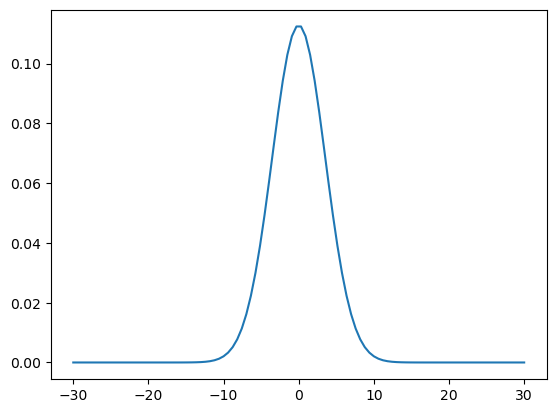

In [178]:
from non_local_detector.likelihoods.common import gaussian_pdf
import matplotlib.pyplot as plt

x = jnp.linspace(-30, 30, 100)
plt.plot(x, gaussian_pdf(x, 0, jnp.sqrt(12.5)))